In [1]:
shrink = True

import math
from functools import partial
from glob import glob
import multiprocessing as mp
import sys
import time

import cv2
from numba import jit
import numpy as np
from scipy.spatial.ckdtree import cKDTree
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from sprites.sprite_util import neighboring_points, get_playthrough
from sprites.jupyter_utils import display_image as show_image
from sprites.jupyter_utils import display_images as show_images

#np.set_printoptions(threshold=10000000, linewidth=1000000000)

@jit(nopython=True)
def quick_parse(img: np.array, ntype, shrink_mask=True):
    if img.shape[-1] == 4:
        visited = (img[:, :, 3] == 0).astype(np.ubyte)
    else:
        visited = np.zeros(img.shape[:-1], dtype=np.ubyte)

    patches = [(0, 0, 0, 0, 0, 0, 0)]  # Give numba's type inference something to work with
    patches.pop()
    masks = [np.zeros((1, 1), dtype=np.ubyte)]  # numba hint
    masks.pop()

    for x in range(len(img)):
        for y in range(len(img[x])):
            if visited[x][y] == True:
                continue

            seed = (x, y)
            patch = [(x, y)]  # Hint for numba's type inference system
            stack = [patch.pop()]
            visited[x][y] = True
            while len(stack) > 0:
                current_pixel = stack.pop()
                patch.append(current_pixel)
                nbr_coords = neighboring_points(current_pixel[0], current_pixel[1], img, ntype)

                for i, j in nbr_coords:
                    if visited[i][j] == False and np.array_equal(img[i][j], img[x][y]):
                        stack.append((i, j))
                        visited[i][j] = True

            patch_arr = np.array(patch, dtype=np.ubyte)
            x_arr = patch_arr[:, 0]
            y_arr = patch_arr[:, 1]

            #x_arr = np.array([c[0] for c in patch_arr])
            #y_arr = np.array([c[1] for c in patch_arr])
            assert(x_arr.shape[0] == patch_arr.shape[0])
            assert(y_arr.shape[0] == patch_arr.shape[0])
            for i in range(len(x_arr)):
                assert(patch_arr[i][0] == x_arr[i])
                assert(patch_arr[i][1] == y_arr[i])

            x1, y1 = min(x_arr), min(y_arr),
            w, h = (max(x_arr) + 1) - x1 , (max(y_arr) + 1) - y1
            nx_arr = x_arr - x1
            ny_arr = y_arr - y1
            mask = np.zeros(img.shape[:-1], dtype=np.ubyte)
            points = []
            for i in range(len(patch_arr)):
                nx = patch_arr[i][0] - x1
                ny = patch_arr[i][1] - y1
                points.append((nx, ny))
                if shrink_mask is True:
                    mask[nx][ny] = 1
                else:
                    mask[patch_arr[i][0]][patch_arr[i][1]] = 1
            if shrink_mask is True:
                mask = mask[:w, :h].copy()
            else:
                mask = mask.copy()
            masks.append(mask)
            patches.append((seed[0], seed[1], len(patch), x1, y1, w, h))

    return np.array(patches, dtype=np.uint32), masks
def par(pt, img_count, ntype, start=0, pool=None):
    p_func = partial(quick_parse, ntype=ntype)
    if pool is None:
        pool = mp.Pool(8)
    #return np.array(pool.map(p_func, pt), dtype=np.int32)
    return pool.map(p_func, pt[start:start+img_count])
def ser(pt, img_count):
    temp = []
    for i, img in enumerate(pt[:img_count]):
        print(i)
        temp.append(quick_parse(img, False))
    return temp


game = 'SuperMarioBros-Nes'
play_number = 1000
frame_number = 0
ntype = False
total_time = 0
sprites = [cv2.imread(f'./sprites/sprites/SuperMarioBros-Nes/{i}.png', cv2.IMREAD_UNCHANGED) for i in [0, 3, 35]]
parsed_sprites = [quick_parse(img, ntype=ntype, shrink_mask=shrink) for img in sprites]
sprite_clouds = [i[0] for i in parsed_sprites]
sprite_masks  = [i[1] for i in parsed_sprites]
sprite_kdt = [cKDTree(data=cloud[:, :2]) for cloud in sprite_clouds]


pt = get_playthrough(play_number, game=game)['raw']
img_count = 1

# Load test image
test_img = cv2.imread('knn_test.png')

start = time.time()

# Parse frame
full_features, masks = quick_parse(test_img, ntype=ntype, shrink_mask=shrink)
features = full_features[:, :2]
total_time += time.time() - start
print('features', time.time() - start, 'average', float(time.time() - start) / float(img_count))

# KDTrees
start = time.time()
tree = cKDTree(data=features)
#trees = [ for f in features]
total_time += time.time() - start
print('trees', time.time() - start, 'average', float(time.time() - start) / float(img_count))

def rect_from_feature(wat, f, color=(0, 255, 0)):
    return cv2.rectangle(wat, (f[4], f[3]), (f[4] + f[6], f[3] + f[5]), color)


features 0.02314472198486328 average 0.023145198822021484
trees 0.0003268718719482422 average 0.00032711029052734375


In [2]:
count = 0
def normalize_knn(kdt, features, k, translate=True):
    if len(kdt.data) == 1:
        return np.zeros((1, k)), np.zeros((1, k, 2))
    dd, ii = kdt.query(features, k=k)
    print('feature', features)
    print('dd', dd)
    
    mag = dd[:, 1:]
    all_coords = np.array([kdt.data[ii[i]] for i in range(ii.shape[0])])
    print('ii', ii)
    print('all_coords', all_coords)
    origins = all_coords[:, 0]
    coords = all_coords[:, 1:]
    print('coords', coords)
    print('origins', origins)
    for i, c in enumerate(coords):
        coords[i] = c - origins[i]
    print('trans', coords)
    flat_coords = coords.reshape((coords.shape[0] * coords.shape[1], 2))
#     print('f', flat_coords[:10])
#     print('t', flat_coords[:10])
    unit_vect = preprocessing.normalize(flat_coords).reshape(coords.shape)
    print('mag', mag)
    print('uv', unit_vect)
    return mag, unit_vect

mario_sprite, mario_cloud, mario_kdt, mario_masks = sprites[1], sprite_clouds[1], sprite_kdt[1], sprite_masks[1]
mmag, muv = normalize_knn(sprite_kdt[1], mario_cloud[:, :2], k=4, translate=False)
tmag, tuv = normalize_knn(tree, features, k=10, translate=False)
mref = 0
tref = 1
print('tmag.shape', tmag.shape)
print('tuv.shape ', tuv.shape)
print()
print(tmag[tref])
print(mmag[mref])
print(tuv[tref])
print(muv[mref])




feature [[ 0 13]
 [ 1  6]
 [ 3  5]
 [ 3  8]
 [ 3 10]
 [ 3 11]
 [ 3 13]
 [ 4  4]
 [ 4  5]
 [ 5 11]
 [ 8  2]
 [ 8  7]
 [ 8  8]
 [ 8 11]
 [ 8 12]
 [ 9  8]
 [ 9 15]
 [10  0]
 [11  9]
 [11 12]
 [12  3]]
dd [[0.         3.         3.60555128 4.24264069]
 [0.         2.23606798 2.82842712 3.16227766]
 [0.         1.         1.41421356 2.23606798]
 [0.         2.         2.82842712 3.        ]
 [0.         1.         2.         2.23606798]
 [0.         1.         2.         2.        ]
 [0.         2.         2.82842712 3.        ]
 [0.         1.         1.41421356 3.60555128]
 [0.         1.         1.         3.16227766]
 [0.         2.         2.23606798 2.82842712]
 [0.         2.82842712 4.12310563 4.47213595]
 [0.         1.         1.41421356 3.60555128]
 [0.         1.         1.         3.        ]
 [0.         1.         3.         3.        ]
 [0.         1.         3.         3.16227766]
 [0.         1.         1.41421356 2.23606798]
 [0.         3.16227766 3.60555128 4.12310563]


features: `[(first_pixel_x, first_pixel_y, area, bounding_box_x1, bounding_box_y1, w, h)]`

In [3]:
np.set_printoptions(threshold=10000000, linewidth=1000000000)
def match_features(tfeat, tmag, tuv, sfeat, smag, suv, p=False):
    smag = smag.copy()
    suv = suv.copy()
    if tfeat[2] != sfeat[2] or tfeat[5] != sfeat[5] or tfeat[6] != sfeat[6]:
        if p is True:
            pass
#             print('nope')
        return False
   
    removed = np.zeros(smag.shape, dtype=np.bool8)
    matches = np.zeros(suv.shape[:1], dtype=np.bool8)
    for i, mag, uv in zip(range(len(tuv)), tmag, tuv):
        
        for j, sm, su in zip(range(len(suv)), smag, suv):
            if removed[j] == True:
                continue
            if np.array_equiv(uv, suv[j]) and np.array_equiv(mag, smag[j]):
                matches[j] = True
                removed[j] = True
                break
            
                if p is True:
                    pass
    #                 print(' mag', mag)
    #                 print('smag', smag[j])
    #                 print(' uv', uv)
    #                 print('suv', suv[j])
               
            elif p is True:
                pass
    #             print('False')
    #             print('uv check', np.array_equiv(uv, suv[j]))
    #             print('mag check', np.array_equiv(mag, smag[j]))
    #             print(' mag', mag)
    #             print('smag', smag[j])
    #             print(' uv', uv)
    #             print('suv', suv[j])
    if p is True:
        pass
        #print('matches', matches)
    if np.all(matches) != True:
#         print('all', np.all(matches))
#         print(type(matches), matches)
#         print('pyall', all(matches))
        return False
    print('returning True')
    return True
def color_mask(img, mask, color=(0, 255, 0)):
    c = np.array(color, dtype=np.ubyte)
    img = img.copy()
    for x, y in zip(*np.nonzero(mask)):
        img[x][y] = c
    return img
t, m = 15, 13
# print(f'target[{t}]')
# print('tfeature', full_features[t])
# print('tnorm', normalize_knn(tree, [features[t]], k=5))
# for i in [15, 16, 14, 11, 22]:
#     #print(i, full_features[i])
#     print(i, masks[i])
# print(f'mario[{m}]')
# print('mfeature', mario_cloud[m])
# print('mnorm', normalize_knn(mario_kdt, [mario_cloud[m][:2]], k=4))
# for i in [13, 14,  9, 12]:
#     #print(i, full_features[i])
#     print(i, mario_masks[i])

print('\n\n\n------------------------- matching -------------------------')
matches = []
smatches = np.zeros((len(mario_cloud)), dtype=np.bool8)
for i, tf in enumerate(full_features):
    #print([match_features(full_features[i], tmag[i], tuv[i], f, m, u) for f, m, u in zip(mario_cloud, mmag, muv)])
    matches.append([match_features(full_features[i], tmag[i], tuv[i], f, m, u, p=True) for f, m, u in zip(mario_cloud, mmag, muv)])
    try:
        smatches[matches[-1].index(True)] = True
    except ValueError:
        pass
    #print([int(j) for j in matches[-1]], sum([int(j) for j in matches[-1]]), i)

print(smatches)
temp = []
with np.printoptions(threshold=10000000, linewidth=1000000000, formatter={'bool': lambda b: '1,' if b else ' ,'}):
    for i, m in enumerate(matches):
        print(f'{i: <3}: {np.array(m, dtype=np.bool8)}')
for i in matches:
    try:
        temp.append(i.index(True))
    except ValueError:
        temp.append(-1)
print(temp)




------------------------- matching -------------------------
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]
0  : [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,]
1  : [1,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,]
2  : [ , 1,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,]
3  : [ ,  , 1,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,]
4  : [ ,  ,  , 1,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,]
5  : [ ,  ,  ,  , 1,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,]
6  : [ ,  ,  ,  ,  , 1,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,]
7  

0


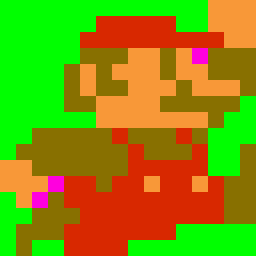

1


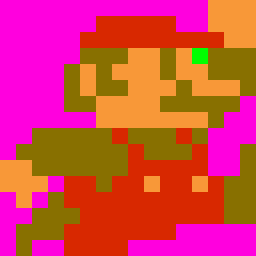

2


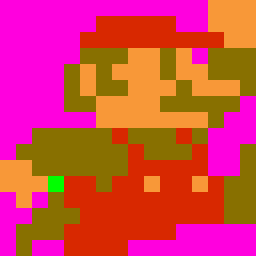

3


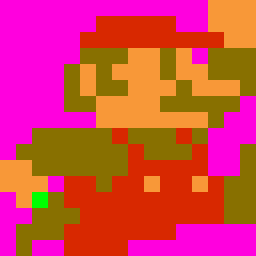

0


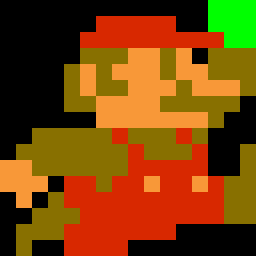

1


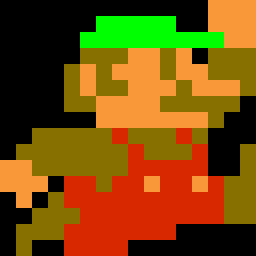

2


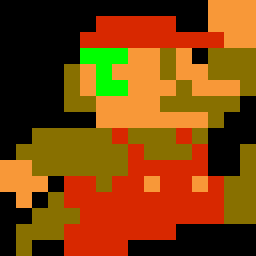

3


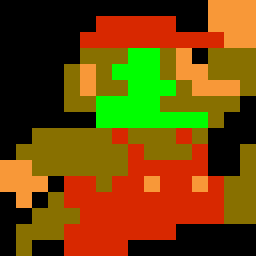

4


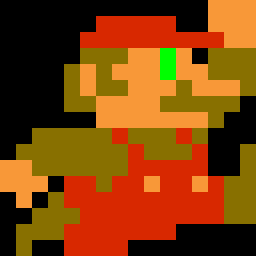

5


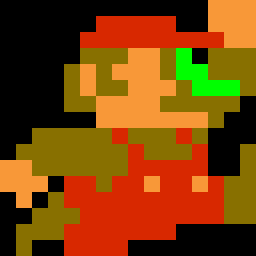

6


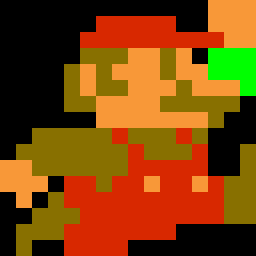

7


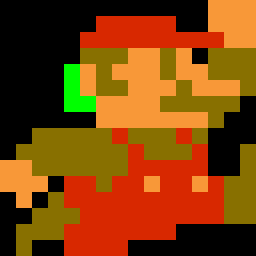

8


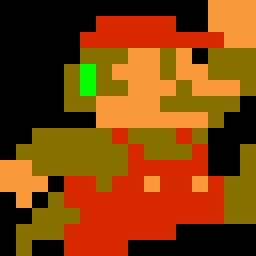

9


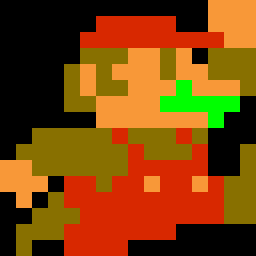

10


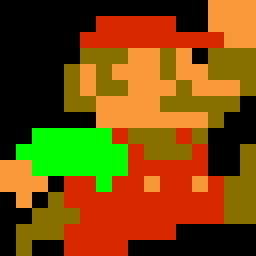

11


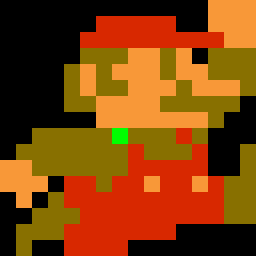

12


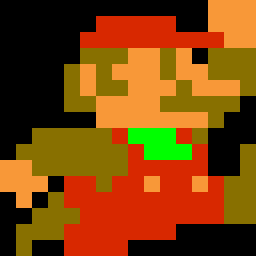

13


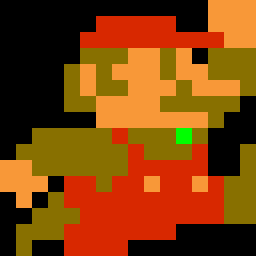

14


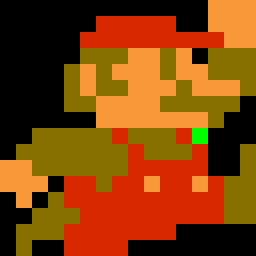

15


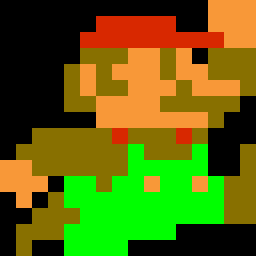

16


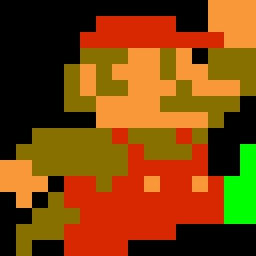

17


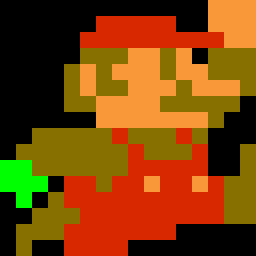

18


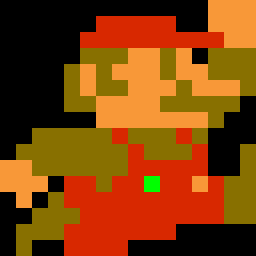

19


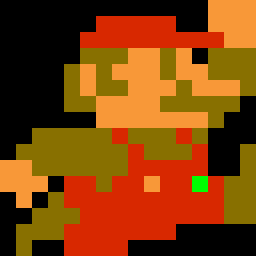

20


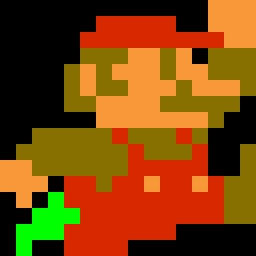

returning True
True
[13 14 17 21 15]
5
1
5


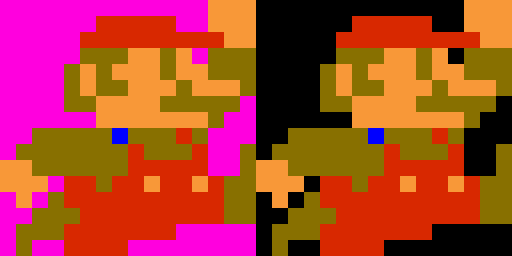

2
5


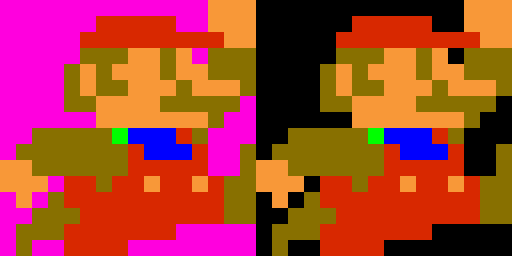

3
5


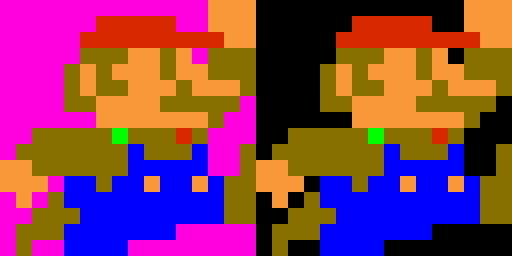

4
5


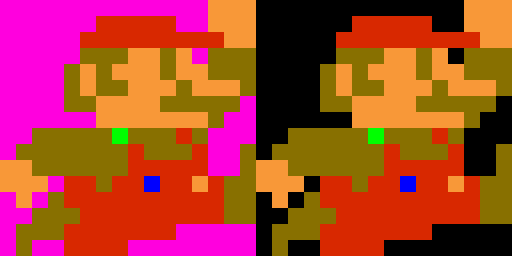

tmag [1.         1.41421356 3.60555128 4.         4.47213595 5.         5.         5.         5.        ]
mmag [1.         1.41421356 3.60555128]

tuv [[ 0.          1.        ]
 [ 0.70710678  0.70710678]
 [ 0.83205029  0.5547002 ]
 [ 0.          1.        ]
 [-0.89442719 -0.4472136 ]
 [ 0.          1.        ]
 [ 0.         -1.        ]
 [ 0.6        -0.8       ]
 [-0.8        -0.6       ]]
muv [[0.         1.        ]
 [0.70710678 0.70710678]
 [0.83205029 0.5547002 ]]

False
[19 12 23 20 24]
5
1
5


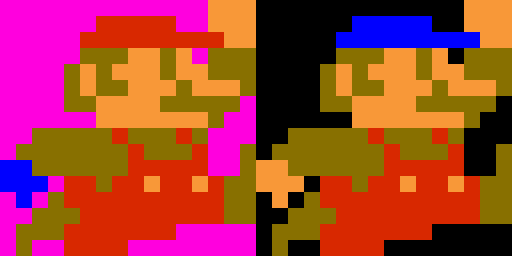

2
5


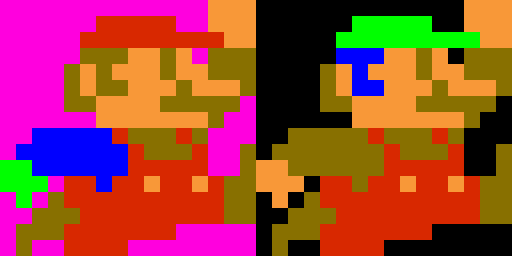

3
5


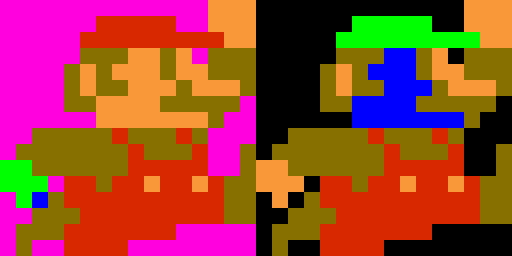

4
5


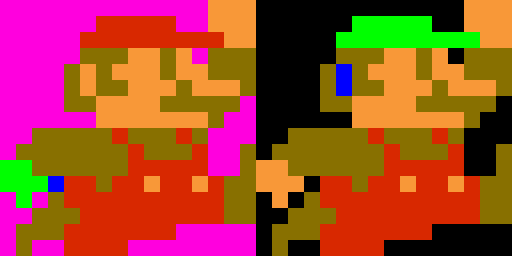

tmag [2.82842712 2.82842712 3.16227766 3.60555128 7.21110255 7.28010989 7.81024968 8.06225775 8.24621125]
mmag [2.23606798 2.82842712 3.16227766]

tuv [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.31622777  0.9486833 ]
 [ 0.5547002   0.83205029]
 [-0.83205029  0.5547002 ]
 [-0.27472113  0.96152395]
 [-0.76822128  0.6401844 ]
 [-0.12403473  0.99227788]
 [-0.24253563  0.9701425 ]]
muv [[ 0.89442719 -0.4472136 ]
 [ 0.70710678  0.70710678]
 [ 0.9486833  -0.31622777]]



In [4]:
np.set_printoptions(threshold=10000000, linewidth=1000000000)
full_features, masks = quick_parse(test_img, ntype=ntype, shrink_mask=False)
mario_cloud, mario_masks = quick_parse(mario_sprite, ntype=ntype, shrink_mask=False)
def color_all_patches(img, masks, scale, color=(0, 255, 0), slice_params=((None, None), (None, None), (None, None))):
    a, b, c = slice_params
    a1, a2 = a
    b1, b2 = b
    c1, c2 = c
    for i, m in enumerate(masks):
        print(i)
        cimg = img.copy()
        cimg = color_mask(cimg, m, color=color)
        show_image(cimg[a1:a2, b1:b2, c1:c2], scale=scale)

img = test_img.copy()
color_all_patches(img, [masks[i] for i in range(len(masks)) if not any(matches[i])], 16, slice_params=((124, 124+16), (105, 105 + 16), (None, None)))
color_all_patches(mario_sprite[:, :, :3], mario_masks, scale=16)

exit
for j, i in [(13, 11),(19, 1)]:
    print(match_features(full_features[j], tmag[j], tuv[j], mario_cloud[i], mmag[i], muv[i]))
#     print(full_features[j])
#     print(mario_cloud[i])
#     print()
    
    dd, ii = tree.query(features[j], k=5)
    print(ii)
    oimg = color_mask(test_img, masks[j])
    #show_image(oimg[124:124+16, 105:105 + 16, :], scale=16)
    temp = []
    for k in ii:
        img = oimg.copy()
        temp.append(color_mask(img, masks[k], color=(255, 0, 0))[124:124+16, 105:105 + 16, :])
    print(len(temp))
    
    dd, ii = mario_kdt.query(mario_cloud[i][:2], k=4)
    oimg = color_mask(mario_sprite[:, :, :3].copy(), mario_masks[i])
    #show_image(oimg, scale=16)
    offset = 0
    for l, k in enumerate(ii):
        
        img = oimg.copy()
        print(l+1)
        print(len(temp))
        temp[l]
        
        show_image(np.concatenate((temp[l], color_mask(img, mario_masks[k], color=(255, 0, 0))), axis=1), scale=16)
    
    
    print('tmag', tmag[j])
    print('mmag', mmag[i])
    print()
    print('tuv', tuv[j])
    print('muv', muv[i])
    print()
    

returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
returning True
[[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], [True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], [False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], [False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], [False, False, False, True, False, False, False, False, False, False, False, False, False, 

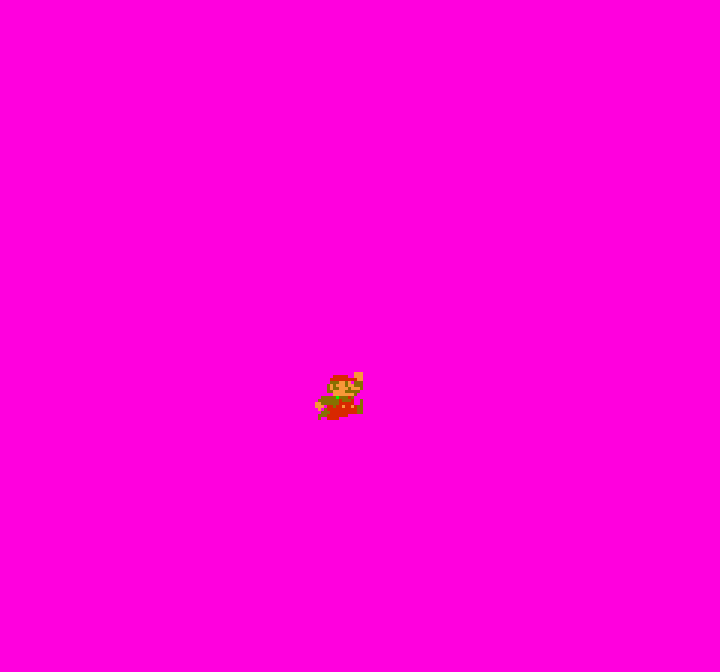

19


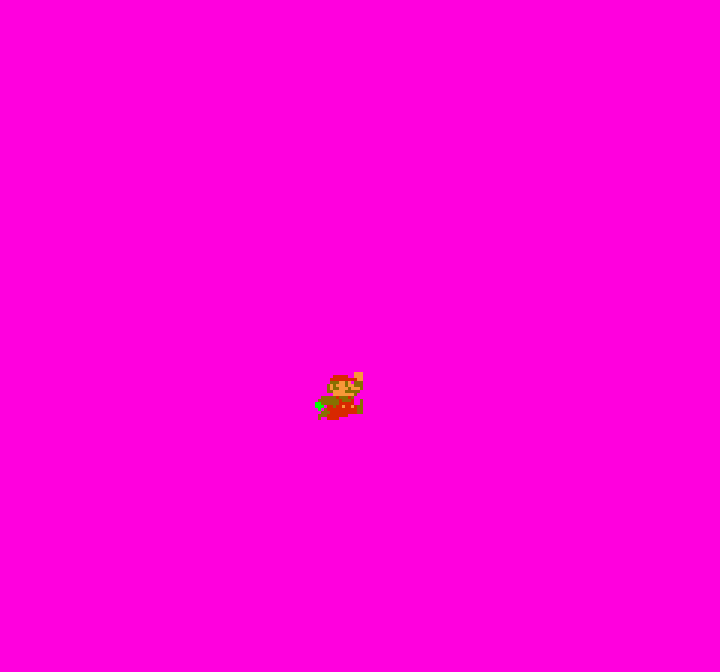

0


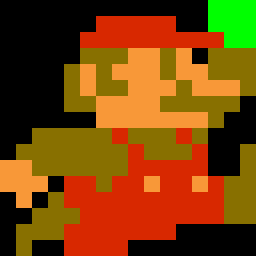

1


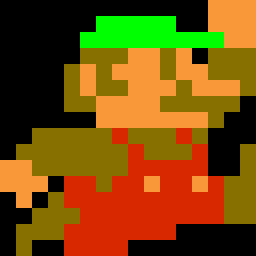

2


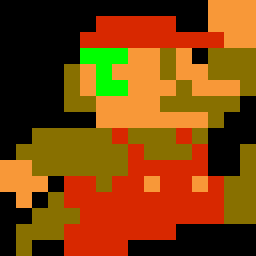

3


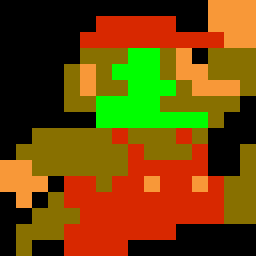

4


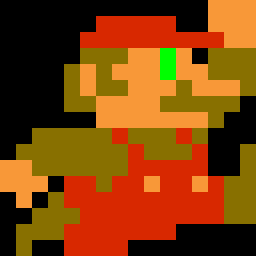

5


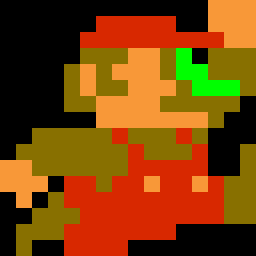

6


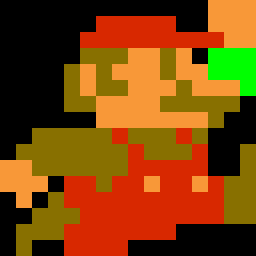

7


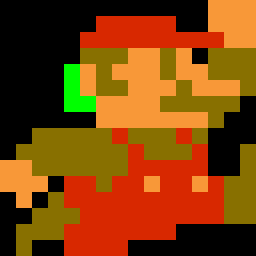

8


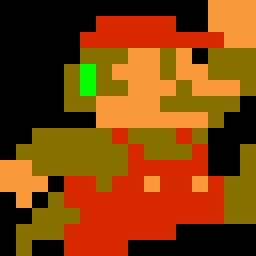

9


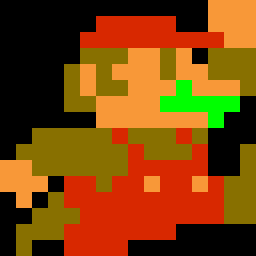

10


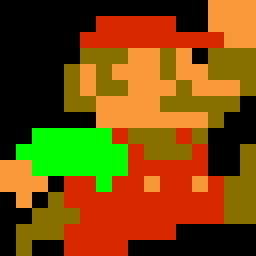

11


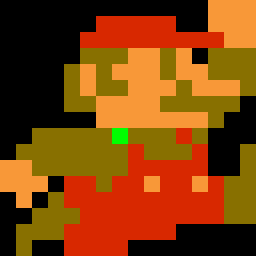

12


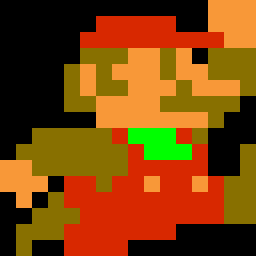

13


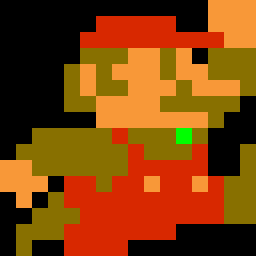

14


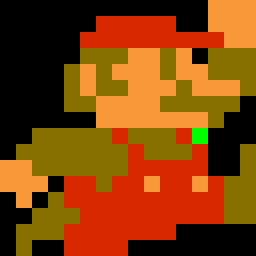

15


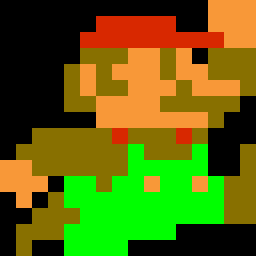

16


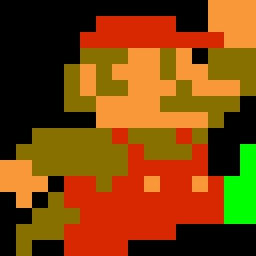

17


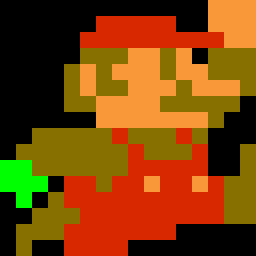

18


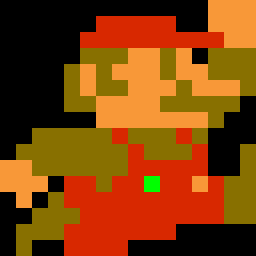

19


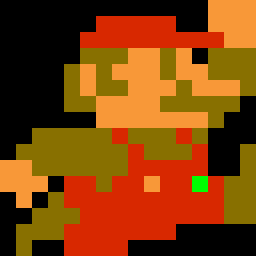

20


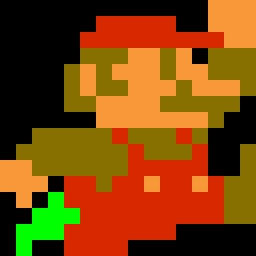

In [5]:
matches = []
smatches = np.zeros((len(mario_cloud)), dtype=np.bool8)
for i, tf in enumerate(full_features):
    matches.append([match_features(full_features[i], tmag[i], tuv[i], f, m, u) for f, m, u in zip(mario_cloud, mmag, muv)])
    try:
        smatches[matches[-1].index(True)] = True
    except ValueError:
        pass
    #print([int(j) for j in matches[-1]], sum([int(j) for j in matches[-1]]), i)
print(matches)
print(smatches)
temp = []
for i in matches:
    try:
        temp.append(i.index(True))
    except ValueError:
        temp.append(-1)
print(temp)

color = np.array([0, 255, 0], dtype=np.ubyte)

# for i in np.where(np.array(smatches) == False)[0]:
#     for j, tf in enumerate(full_features):
#         print('i', i)
#         match_features(full_features[j], tmag[j], tuv[j], mario_cloud[i], mmag[i], muv[i], p=True)
#         print()

for i in [13, 19]:
    img = test_img.copy()

    print(i)
    #print('zipped', list(zip(*np.nonzero(masks[i]))))
    for x, y in zip(*np.nonzero(masks[i])):
        img[x][y] = color
    show_image(img, scale=3)

for j, i in enumerate(mario_masks):
    img = mario_sprite[:, :, :3].copy()
    print(j)
    #print('zipped', list(zip(*np.nonzero(masks[i]))))
    for x, y in zip(*np.nonzero(i)):
        img[x][y] = color
    show_image(img, scale=16)


In [7]:
# Normalize vectors


# Match points
start = time.time()

matches = [(i, f) for i, f in enumerate(mario_cloud) if f[2] == 8]
rects = []
for i, f in matches:
    print(i)
    rects.append(cv2.rectangle(mario_sprite.copy(), (f[4], f[3]), (f[4] + f[6], f[3] + f[5]), (0, 255, 0)))
#show_image(rect, scale=3)
#print(m_mag[0])
#print(m_uv[0])

print('target', full_features[1])
rnorm = (np.round(norm[0], decimals=5), np.round(norm[1], decimals=5))
match_features(full_features[1], (rnorm[0][1], rnorm[1][1]), mario_cloud, (np.round(m_mag, decimals=5), np.round(m_uv, decimals=5)))
#indx = [index(full_features, norm[0], norm[1], mario_cloud, m_mag, m_uv) for i, n in enumerate(norm)]
total_time += time.time() - start
print('indexing', time.time() - start, 'average', float(time.time() - start) / float(img_count))
print('total', total_time, 'average', float(total_time) / float(img_count))

print(norm[0][0].shape, norm[0][1].shape)

0
16
20
target [124 118   8 124 118   3   3]


NameError: name 'norm' is not defined

In [125]:
count = 0
def normalize_knn(kdt, features, k, translate=True):
#     global test_img
#     global mario_sprite
#     global full_features
#     global mario_cloud
#     global count
#     ti, ms, ff, mc= test_img, mario_sprite, full_features, mario_cloud
    
    if len(kdt.data) == 1:
        return np.zeros((1, k)), np.zeros((1, k, 2))
    dd, ii = kdt.query(features, k=k)
    mag = dd[:, 1:]
    all_coords = np.array([kdt.data[ii[i]] for i in range(ii.shape[0])])
#     if count == 0:
#         ms3 = cv2.cvtColor(ms.copy(), cv2.COLOR_BGRA2BGR)
#         img = ms3.copy()
#         img1 = rect_from_feature(img.copy(), mc[ii[0][0]], color=(255, 255, 255))
#         img2 = rect_from_feature(img1.copy(), mc[ii[0][1]], color=(255, 255, 0))
#         img3 = rect_from_feature(img1.copy(), mc[ii[0][2]], color=(255, 0, 0))
#         img4 = rect_from_feature(img1.copy(), mc[ii[0][3]], color=(0, 255, 0))
#         xs, ys, d = ms3.shape
#         i = np.zeros((xs, ys * 2, d))

#         i1 = i.copy()
#         i1[:xs, :ys] = ms3
#         i2 = i1.copy()
#         i3 = i1.copy()
#         i4 = i1.copy()        

#         i1[:xs, ys:] = img1
#         i2[:xs, ys:] = img2
#         i3[:xs, ys:] = img3
#         i4[:xs, ys:] = img4
#         show_image(i1, scale=16)
#         show_image(i2, scale=16)
#         show_image(i3, scale=16)
#         show_image(i4, scale=16)
#     elif count == 1:
#         img = ti.copy()
#         img1 = rect_from_feature(img.copy(), full_features[ii[1][0]], color=(255, 255, 255))
#         img2 = rect_from_feature(img1.copy(), full_features[ii[1][1]], color=(255, 255, 0))
#         img3 = rect_from_feature(img1.copy(), full_features[ii[1][2]], color=(255, 0, 0))
#         img4 = rect_from_feature(img1.copy(), full_features[ii[1][3]], color=(0, 255, 0))
#         xs, ys, d = ti[122:143, 101:122].shape
#         i = np.zeros((xs, ys * 2, d))
#         i1 = i.copy()

#         i1[:xs, :ys] = ti[122:143, 101:122]
#         i2 = i1.copy()
#         i3 = i1.copy()
#         i4 = i1.copy()
        
#         i1[:xs, ys:] = img1[122:143, 101:122]
#         i2[:xs, ys:] = img2[122:143, 101:122]
#         i3[:xs, ys:] = img3[122:143, 101:122]
#         i4[:xs, ys:] = img4[122:143, 101:122]
#         show_image(i1, scale=16)
#         show_image(i2, scale=16)
#         show_image(i3, scale=16)
#         show_image(i4, scale=16)
#     count += 1
    origins = all_coords[:, 1]
    coords = all_coords[:, 1:]
    for i, c in enumerate(coords):
        coords[i] = c - origins[i]
    flat_coords = coords.reshape((coords.shape[0] * coords.shape[1], 2))
#     print('f', flat_coords[:10])
#     print('t', flat_coords[:10])
    unit_vect = preprocessing.normalize(flat_coords).reshape(coords.shape)
    return mag, unit_vect

mario_sprite, mario_cloud, mario_kdt, mario_masks = sprites[1], sprite_clouds[1], sprite_kdt[1], sprite_masks[1]
mmag, muv = normalize_knn(sprite_kdt[1], mario_cloud[:, :2], k=4, translate=False)
tmag, tuv = normalize_knn(tree, features, k=10, translate=False)
mref = 0
tref = 1
print('tmag.shape', tmag.shape)
print('tuv.shape ', tuv.shape)
print()
print(tmag[tref])
print(mmag[mref])
print(tuv[tref])
print(muv[mref])




tmag.shape (25, 9)
tuv.shape  (25, 9, 2)

[3.         3.16227766 3.60555128 4.24264069 5.38516481 5.83095189 7.07106781 8.06225775 8.24621125]
[3.         3.60555128 4.24264069]
[[ 0.          0.        ]
 [ 0.         -1.        ]
 [ 0.         -1.        ]
 [ 0.         -1.        ]
 [ 0.70710678 -0.70710678]
 [ 0.         -1.        ]
 [-0.27472113 -0.96152395]
 [ 0.98058068 -0.19611614]
 [ 0.92847669 -0.37139068]]
[[ 0.  0.]
 [ 0. -1.]
 [ 0. -1.]]


In [32]:
np.set_printoptions(threshold=10000000, linewidth=1000000000)
def match_features(tfeat, tmag, tuv, sfeat, smag, suv, p=False):
    smag = smag.copy()
    suv = suv.copy()
    if tfeat[2] != sfeat[2] or tfeat[5] != sfeat[5] or tfeat[6] != sfeat[6]:
        if p is True:
            pass
#             print('nope')
        return False
    
    removed = np.zeros(smag.shape, dtype=np.bool8)
    matches = np.zeros(suv.shape[:1], dtype=np.bool8)
    for i, mag, uv in zip(range(len(tuv)), tmag, tuv):
        if suv_index == len(suv):
            break
        matching_index = -1
        for j, sm, su in zip(range(len(suv)), smag, suv):
            if removed == True:
                continue
            if np.array_equiv(uv, suv[j]) and np.array_equiv(mag, smag[j]):
                matches[j] = True
            
            if p is True:
                pass
#                 print(' mag', mag)
#                 print('smag', smag[suv_index])
#                 print(' uv', uv)
#                 print('suv', suv[suv_index])
            suv_index += 1
        elif p is True:
            pass
#             print('False')
#             print('uv check', np.array_equiv(uv, suv[suv_index]))
#             print('mag check', np.array_equiv(mag, smag[suv_index]))
#             print(' mag', mag)
#             print('smag', smag[suv_index])
#             print(' uv', uv)
#             print('suv', suv[suv_index])
    if p is True:
        pass
        #print('matches', matches)
    if np.all(matches) != True:
#         print('all', np.all(matches))
#         print(type(matches), matches)
#         print('pyall', all(matches))
        return False
    print('returning True')
    return True

def color_mask(img, mask, color=(0, 255, 0)):
    c = np.array(color, dtype=np.ubyte)
    img = img.copy()
    for x, y in zip(*np.nonzero(mask)):
        img[x][y] = c
    return img
t, m = 15, 13
print(f'target[{t}]')
print('tfeature', full_features[t])
print('tnorm', normalize_knn(tree, [features[t]], k=5))
for i in [15, 16, 14, 11, 22]:
    #print(i, full_features[i])
    print(i, masks[i])
print(f'mario[{m}]')
print('mfeature', mario_cloud[m])
print('mnorm', normalize_knn(mario_kdt, [mario_cloud[m][:2]], k=4))
for i in [13, 14,  9, 12]:
    #print(i, full_features[i])
    print(i, mario_masks[i])

print('\n\n\n------------------------- matching -------------------------')
matches = []
smatches = np.zeros((len(mario_cloud)), dtype=np.bool8)
for i, tf in enumerate(full_features):
    #print([match_features(full_features[i], tmag[i], tuv[i], f, m, u) for f, m, u in zip(mario_cloud, mmag, muv)])
    matches.append([match_features(full_features[i], tmag[i], tuv[i], f, m, u, p=True) for f, m, u in zip(mario_cloud, mmag, muv)])
    try:
        smatches[matches[-1].index(True)] = True
    except ValueError:
        pass
    #print([int(j) for j in matches[-1]], sum([int(j) for j in matches[-1]]), i)
print(matches)
print(smatches)
temp = []
for i in matches:
    try:
        temp.append(i.index(True))
    except ValueError:
        temp.append(-1)
print(temp)

target[15]
tfeature [132 116   1 132 116   1   1]
feature [array([132, 116], dtype=uint32)]
dd [[0.         1.         3.         3.         3.16227766]]
ii [[15 16 14 11 22]]
all_coords [[[132. 116.]
  [132. 117.]
  [132. 113.]
  [129. 116.]
  [135. 117.]]]
coords [[[132. 117.]
  [132. 113.]
  [129. 116.]
  [135. 117.]]]
origins [[132. 116.]]
trans [[[ 0.  1.]
  [ 0. -3.]
  [-3.  0.]
  [ 3.  1.]]]
mag [[1.         3.         3.         3.16227766]]
uv [[[ 0.          1.        ]
  [ 0.         -1.        ]
  [-1.          0.        ]
  [ 0.9486833   0.31622777]]]
tnorm (array([[1.        , 3.        , 3.        , 3.16227766]]), array([[[ 0.        ,  1.        ],
        [ 0.        , -1.        ],
        [-1.        ,  0.        ],
        [ 0.9486833 ,  0.31622777]]]))
15 [[1]]
16 [[1]]
14 [[1 1 1 0]
 [0 1 1 1]]
11 [[0 1 0 0 0]
 [1 1 1 1 1]
 [0 0 0 1 0]]
22 [[1]]
mario[13]
mfeature [ 8 11  1  8 11  1  1]
feature [array([ 8, 11], dtype=uint32)]
dd [[0. 1. 3. 3.]]
ii [[13 14  9 12]]
